In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from PIL import Image

In [124]:
# Load the dataset
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

print(train_images.shape) # (20000, 28, 28)
print(train_labels.shape) # (20000,)
print(test_images.shape) # (5000, 28, 28)
print(test_labels.shape) # (5000,)

(20000, 28, 28)
(20000,)
(5000, 28, 28)
(5000,)


In [125]:
# Convert numpy arrays to torch tensors
train_tensor = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 28, 28)
test_tensor = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)

# Normalize to [0, 1]
train_tensor /= 255.0
test_tensor /= 255.0

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)


In [133]:
# Define the CNN Autoencoder
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [134]:
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # I only used cpu in my google colab, but anyways.
model = CNNAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
train_losses = []


Epoch 1/20, Loss: 0.0926
Epoch 2/20, Loss: 0.0336
Epoch 3/20, Loss: 0.0207
Epoch 4/20, Loss: 0.0139
Epoch 5/20, Loss: 0.0095
Epoch 6/20, Loss: 0.0079
Epoch 7/20, Loss: 0.0068
Epoch 8/20, Loss: 0.0059
Epoch 9/20, Loss: 0.0052
Epoch 10/20, Loss: 0.0048
Epoch 11/20, Loss: 0.0046
Epoch 12/20, Loss: 0.0044
Epoch 13/20, Loss: 0.0043
Epoch 14/20, Loss: 0.0043
Epoch 15/20, Loss: 0.0042
Epoch 16/20, Loss: 0.0042
Epoch 17/20, Loss: 0.0041
Epoch 18/20, Loss: 0.0041
Epoch 19/20, Loss: 0.0040
Epoch 20/20, Loss: 0.0040


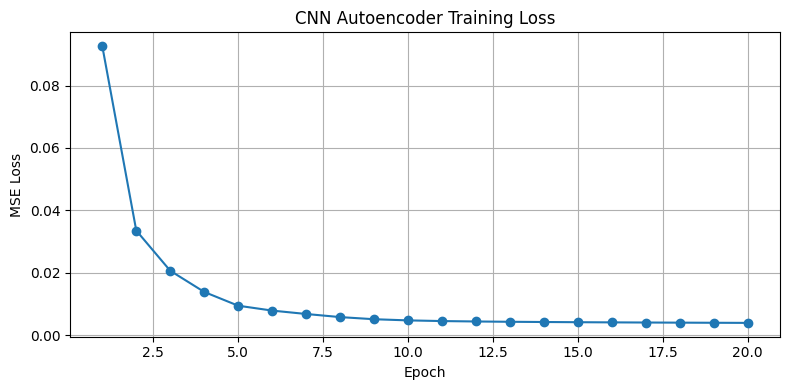

In [135]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        imgs = batch[0].to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Plot MSE loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title("CNN Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.tight_layout()
plt.show()

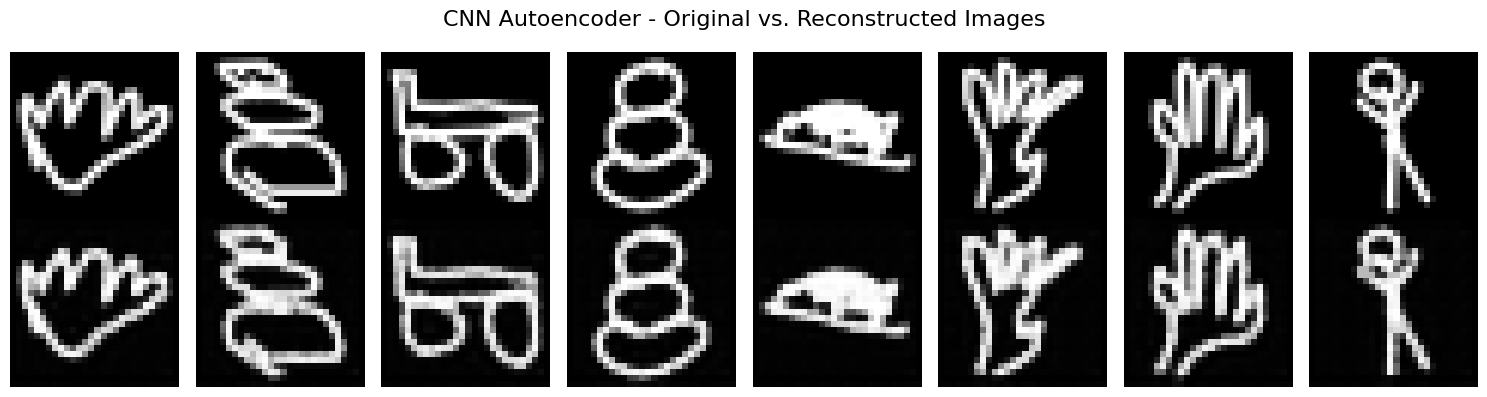

In [136]:
## visualize reconstructions
# Switch model to evaluation
model.eval()

# Get a batch from test set
with torch.no_grad():
    test_batch = next(iter(test_loader))[0][:8].to(device)  # First 8 images
    recon_batch = model(test_batch)

# Plot original and reconstructed images
fig, axs = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axs[0, i].imshow(test_batch[i].cpu().squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon_batch[i].cpu().squeeze(), cmap='gray')
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", size=14)
axs[1, 0].set_ylabel("Reconstructed", size=14)
plt.suptitle("CNN Autoencoder - Original vs. Reconstructed Images", fontsize=16)
plt.tight_layout()
plt.show()


In [137]:
from sklearn.manifold import TSNE

# Wrap test data and labels into a proper dataset
test_dataset = TensorDataset(test_tensor, torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract embeddings and labels
model.eval()
latents = []
labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        encoded = model.encoder(x_batch).view(x_batch.size(0), -1)
        latents.append(encoded.cpu())
        labels.extend(y_batch.numpy())

latents = torch.cat(latents, dim=0).numpy()
labels = np.array(labels)

print("Latents shape:", latents.shape)
print("Labels shape:", labels.shape)
print("Unique labels:", np.unique(labels))


Latents shape: (5000, 392)
Labels shape: (5000,)
Unique labels: [0 1 2 3 4]


<ipython-input-138-c79b0fac305e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', 5)  # Only 5 colors


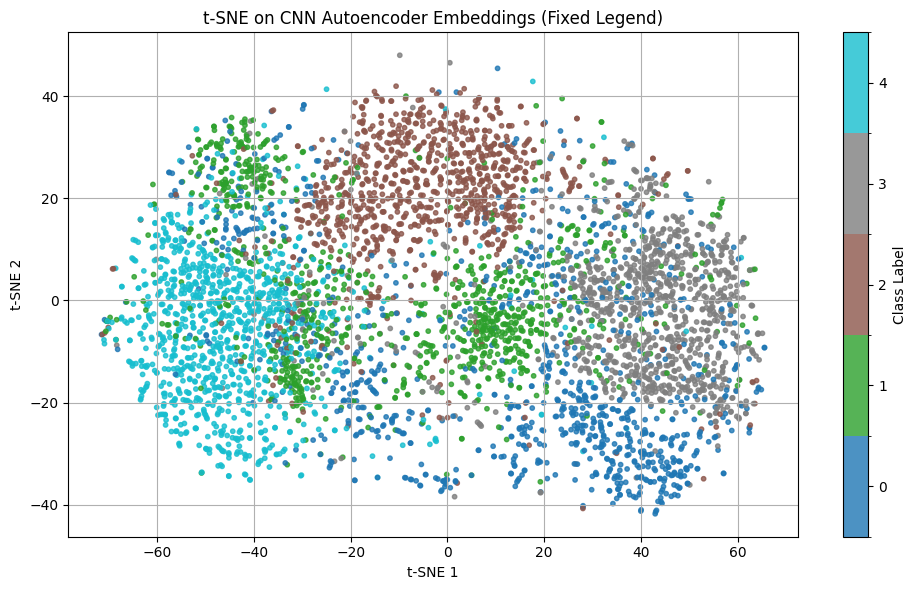

In [138]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_2d = tsne.fit_transform(latents)

# Plot
import matplotlib.cm as cm
import matplotlib.colors as mcolors
# Define discrete colormap for 5 classes
cmap = cm.get_cmap('tab10', 5)  # Only 5 colors
norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 5.5, 1), ncolors=5)

# Plot with discrete colorbar
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    latents_2d[:, 0], latents_2d[:, 1],
    c=labels, cmap=cmap, norm=norm, s=10, alpha=0.8
)

# Add correct colorbar with ticks at 0–4
cbar = plt.colorbar(scatter, ticks=[0, 1, 2, 3, 4])
cbar.set_label('Class Label')

plt.title("t-SNE on CNN Autoencoder Embeddings (Fixed Legend)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("Unique labels:", np.unique(train_labels), np.unique(test_labels))


Unique labels: [0 1 2 3 4] [0 1 2 3 4]


In [139]:
## LSTM AutoEncoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=28, hidden_dim=16, latent_dim=8, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_enc = nn.Linear(hidden_dim, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # x: (batch, time, features) = (B, 28, 28)
        enc_out, (h_n, _) = self.encoder(x)  # Take last hidden state
        z = self.fc_enc(h_n[-1])             # z: (B, latent_dim)

        h_dec = self.fc_dec(z).unsqueeze(0)  # back to (1, B, hidden_dim)
        c_dec = torch.zeros_like(h_dec)      # init decoder cell state

        # Repeat input (not ideal, but works): decoder is trained to reproduce input
        dec_input = x
        dec_out, _ = self.decoder(dec_input, (h_dec, c_dec))
        x_hat = self.output_layer(dec_out)   # (B, 28, 28)
        return x_hat


In [140]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
model = LSTMAutoencoder()
print(f"LSTM AE total parameters: {count_parameters(model):,}")
model = CNNAutoencoder()
print(f"Conv. AE total parameters: {count_parameters(model):,}")


LSTM AE total parameters: 6,644
Conv. AE total parameters: 665


In [141]:
# Reshape image tensors for LSTM (B, T, F) = (B, 28, 28)
train_seq = train_tensor.squeeze(1)  # remove channel dim
test_seq = test_tensor.squeeze(1)

# DataLoader
train_loader = DataLoader(TensorDataset(train_seq), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_seq), batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
lstm_autoencoder = LSTMAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_autoencoder.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
lstm_train_losses = []

for epoch in range(num_epochs):
    lstm_autoencoder.train()
    total_loss = 0
    for batch in train_loader:
        seqs = batch[0].to(device)  # (B, 28, 28)
        recon = lstm_autoencoder(seqs)
        loss = criterion(recon, seqs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * seqs.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    lstm_train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/20, Loss: 0.0597
Epoch 2/20, Loss: 0.0175
Epoch 3/20, Loss: 0.0096
Epoch 4/20, Loss: 0.0072
Epoch 5/20, Loss: 0.0062
Epoch 6/20, Loss: 0.0057
Epoch 7/20, Loss: 0.0054
Epoch 8/20, Loss: 0.0052
Epoch 9/20, Loss: 0.0051
Epoch 10/20, Loss: 0.0050
Epoch 11/20, Loss: 0.0050
Epoch 12/20, Loss: 0.0049
Epoch 13/20, Loss: 0.0049
Epoch 14/20, Loss: 0.0049
Epoch 15/20, Loss: 0.0048
Epoch 16/20, Loss: 0.0048
Epoch 17/20, Loss: 0.0048
Epoch 18/20, Loss: 0.0048
Epoch 19/20, Loss: 0.0048
Epoch 20/20, Loss: 0.0048


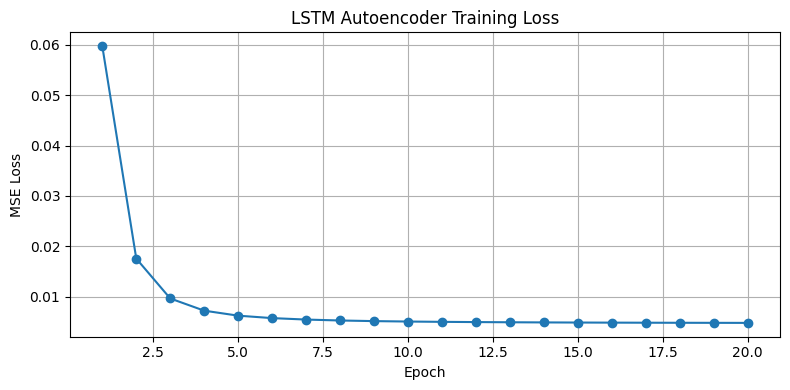

In [142]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), lstm_train_losses, marker='o')
plt.title("LSTM Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.tight_layout()
plt.show()


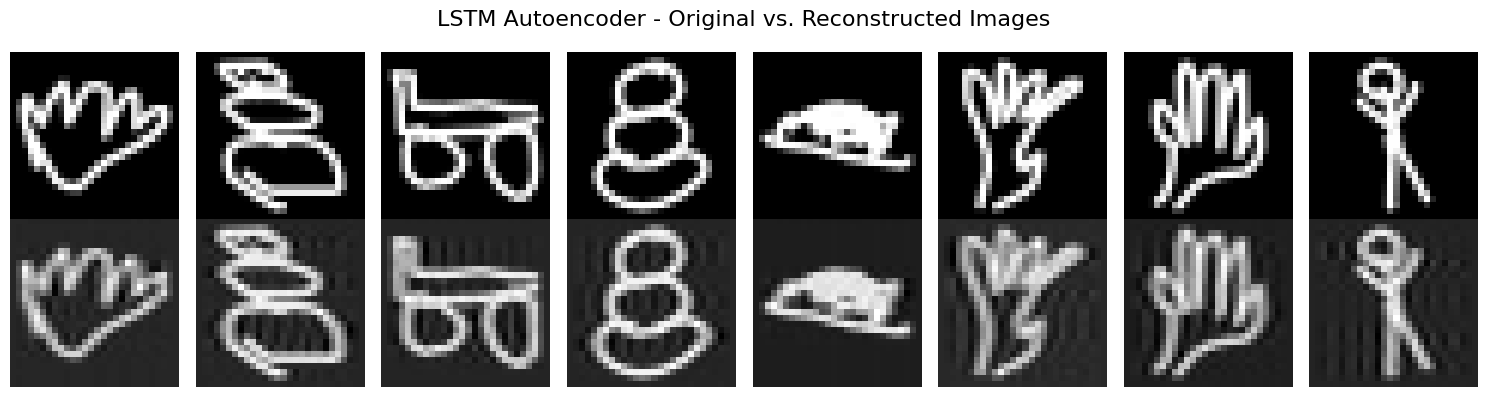

In [143]:
lstm_autoencoder.eval()
with torch.no_grad():
    sample = next(iter(test_loader))[0][:8].to(device)
    recon = lstm_autoencoder(sample)

fig, axs = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axs[0, i].imshow(sample[i].cpu().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i].cpu().numpy(), cmap='gray')
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", size=14)
axs[1, 0].set_ylabel("Reconstructed", size=14)
plt.suptitle("LSTM Autoencoder - Original vs. Reconstructed Images", fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-144-0e30e267e0f5>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c=lstm_labels, cmap=cm.get_cmap('tab10', 5),


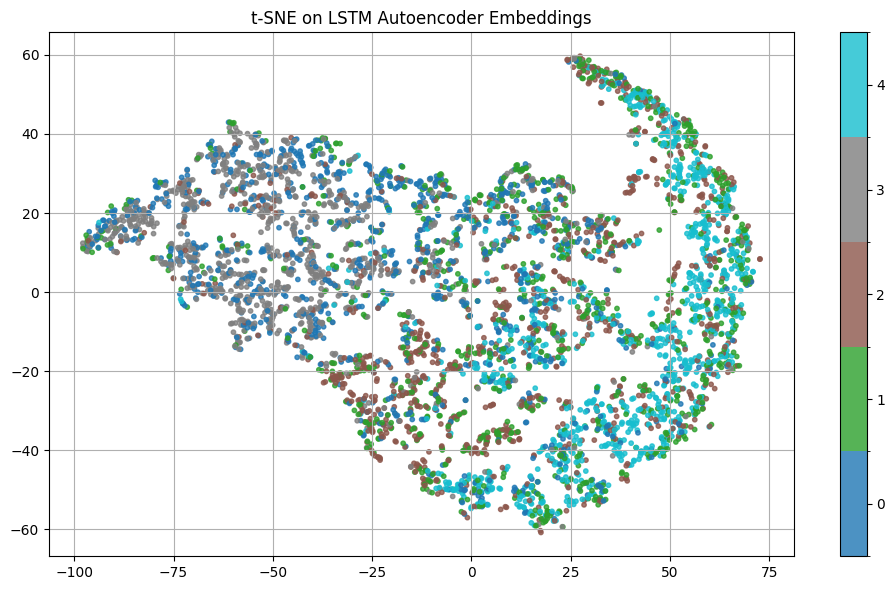

In [144]:
# Prepare test_loader with labels
test_dataset = TensorDataset(test_seq, torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract latent representations
lstm_autoencoder.eval()
lstm_latents, lstm_labels = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        _, (h_n, _) = lstm_autoencoder.encoder(x_batch)
        z = lstm_autoencoder.fc_enc(h_n[-1])
        lstm_latents.append(z.cpu())
        lstm_labels.extend(y_batch.numpy())

lstm_latents = torch.cat(lstm_latents).numpy()
lstm_labels = np.array(lstm_labels)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
lstm_tsne = tsne.fit_transform(lstm_latents)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    lstm_tsne[:, 0], lstm_tsne[:, 1],
    c=lstm_labels, cmap=cm.get_cmap('tab10', 5),
    norm=mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 5.5, 1), ncolors=5),
    s=10, alpha=0.8
)
plt.colorbar(scatter, ticks=[0, 1, 2, 3, 4])
plt.title("t-SNE on LSTM Autoencoder Embeddings")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# The t-SNE projection of LSTM Autoencoder embeddings shows more overlap across classes compared to the CNN autoencoder.
# This is likely due to the sequential nature of LSTM, which does not inherently capture 2D spatial structure in image data.
# While LSTM can still reconstruct input sequences reasonably well, the learned embeddings are less discriminative across categories.

In [ ]:
## Part 2

In [145]:
class VAE_RNN_Encoder_CNN_Decoder(nn.Module):
    def __init__(self, input_dim=28, hidden_dim=128, latent_dim=32):
        super(VAE_RNN_Encoder_CNN_Decoder, self).__init__()

        # LSTM encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: z -> reshape to (B, C, H, W)
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),    # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x_seq):
        _, (h_n, _) = self.encoder_lstm(x_seq)  # h_n: (1, B, H)
        h_n = h_n[-1]  # (B, H)
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x_seq):
        mu, logvar = self.encode(x_seq)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [146]:
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl, recon_loss, kl


In [91]:
vae = VAE_RNN_Encoder_CNN_Decoder().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

vae_train_losses = []
kl_divs = []
recon_terms = []

for epoch in range(num_epochs):
    vae.train()
    total_loss, total_kl, total_recon = 0, 0, 0

    for batch in train_loader:
        x_seq = batch[0].to(device)  # (B, 28, 28)
        x_input = x_seq.unsqueeze(1)  # For image comparison: (B, 1, 28, 28)

        recon, mu, logvar = vae(x_seq)
        loss, recon_loss, kl_loss = vae_loss_function(recon, x_input, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    vae_train_losses.append(avg_loss)
    kl_divs.append(total_kl / len(train_loader.dataset))
    recon_terms.append(total_recon / len(train_loader.dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {avg_loss:.4f}, Recon: {recon_terms[-1]:.4f}, KL: {kl_divs[-1]:.4f}")


Epoch 1/20, Total Loss: 84.6451, Recon: 80.7229, KL: 3.9222
Epoch 2/20, Total Loss: 69.7032, Recon: 66.1492, KL: 3.5539
Epoch 3/20, Total Loss: 65.8527, Recon: 61.7926, KL: 4.0601
Epoch 4/20, Total Loss: 64.1795, Recon: 59.6749, KL: 4.5046
Epoch 5/20, Total Loss: 63.2590, Recon: 58.2041, KL: 5.0549
Epoch 6/20, Total Loss: 62.3989, Recon: 56.7835, KL: 5.6154
Epoch 7/20, Total Loss: 61.5850, Recon: 55.3096, KL: 6.2753
Epoch 8/20, Total Loss: 60.9865, Recon: 54.1955, KL: 6.7910
Epoch 9/20, Total Loss: 60.6075, Recon: 53.4013, KL: 7.2063
Epoch 10/20, Total Loss: 60.2130, Recon: 52.6453, KL: 7.5676
Epoch 11/20, Total Loss: 59.8814, Recon: 52.0539, KL: 7.8275
Epoch 12/20, Total Loss: 59.6261, Recon: 51.5624, KL: 8.0637
Epoch 13/20, Total Loss: 59.3594, Recon: 51.1138, KL: 8.2456
Epoch 14/20, Total Loss: 59.1668, Recon: 50.6955, KL: 8.4713
Epoch 15/20, Total Loss: 58.8922, Recon: 50.2703, KL: 8.6219
Epoch 16/20, Total Loss: 58.6893, Recon: 49.8710, KL: 8.8183
Epoch 17/20, Total Loss: 58.5551,

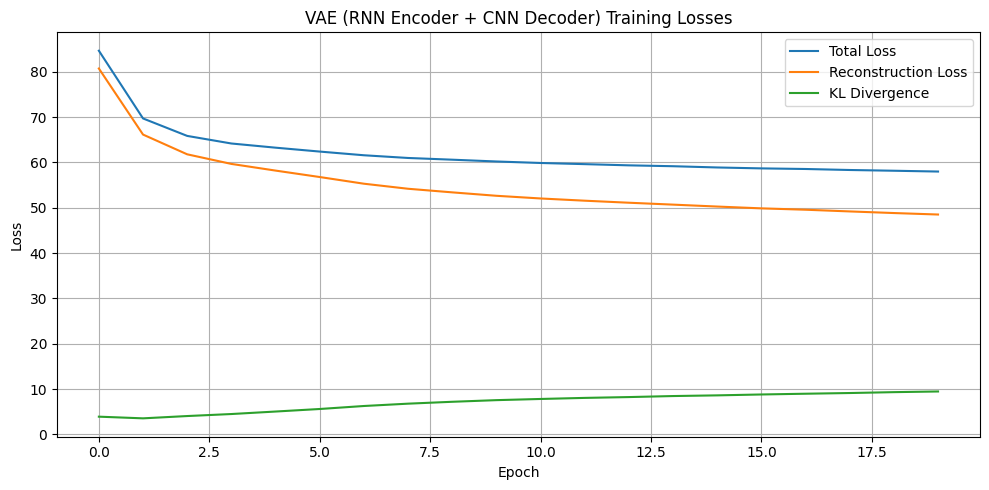

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(vae_train_losses, label='Total Loss')
plt.plot(recon_terms, label='Reconstruction Loss')
plt.plot(kl_divs, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE (RNN Encoder + CNN Decoder) Training Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


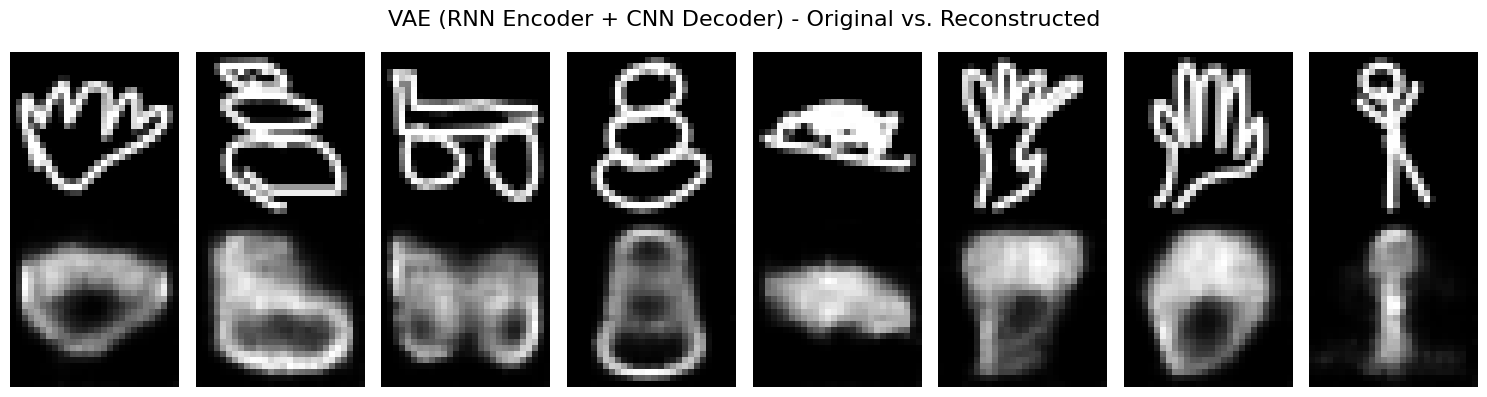

In [93]:
##Visualize Reconstructions
vae.eval()
with torch.no_grad():
    sample = next(iter(test_loader))[0][:8].to(device)
    recon, _, _ = vae(sample)

fig, axs = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axs[0, i].imshow(sample[i].cpu().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')  # recon is (B, 1, 28, 28)
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", size=14)
axs[1, 0].set_ylabel("Reconstructed", size=14)
plt.suptitle("VAE (RNN Encoder + CNN Decoder) - Original vs. Reconstructed", fontsize=16)
plt.tight_layout()
plt.show()


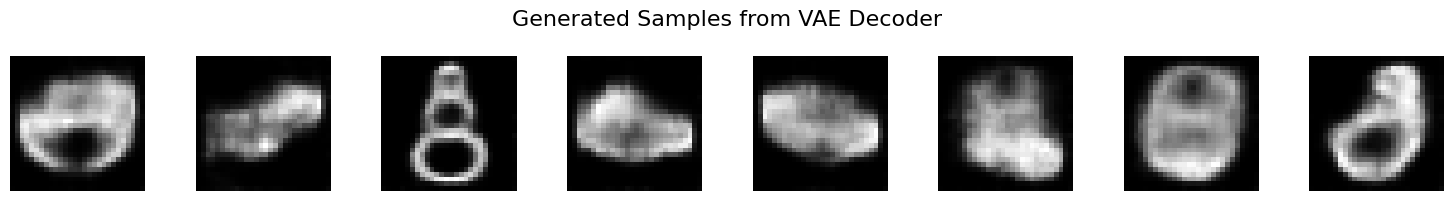

In [94]:
## Sample from the Latent Space
with torch.no_grad():
    z_samples = torch.randn(8, vae.fc_decode.in_features).to(device)  # When I change the latent dim as an experiment, this code should run smoothly.
    gen_images = vae.decode(z_samples)         # shape: (8, 1, 28, 28)

# Plot generated samples
fig, axs = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    axs[i].imshow(gen_images[i].cpu().squeeze(), cmap='gray')
    axs[i].axis('off')
plt.suptitle("Generated Samples from VAE Decoder", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
## part2.2


In [103]:
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [104]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


vae_rnn_cnn = VAE_RNN_Encoder_CNN_Decoder()
vae_cnn = VAE_CNN()

print(f"VAE with RNN encoder and CNN decoder: {count_parameters(vae_rnn_cnn):,} parameters")
print(f"VAE with CNN encoder and decoder:      {count_parameters(vae_cnn):,} parameters")


VAE with RNN encoder and CNN decoder: 211,393 parameters
VAE with CNN encoder and decoder:      370,945 parameters


In [105]:
#Prepare Image Tensors and Train
vae_cnn = VAE_CNN().to(device)
optimizer = torch.optim.Adam(vae_cnn.parameters(), lr=1e-3)

vae_cnn_losses = []
vae_cnn_kl = []
vae_cnn_recon = []

for epoch in range(num_epochs):
    vae_cnn.train()
    total_loss = total_kl = total_recon = 0

    for batch in train_loader:
        x = batch[0].unsqueeze(1).to(device)  # (B, 1, 28, 28)
        recon, mu, logvar = vae_cnn(x)
        loss, recon_loss, kl = vae_loss_function(recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    vae_cnn_losses.append(avg_loss)
    vae_cnn_kl.append(total_kl / len(train_loader.dataset))
    vae_cnn_recon.append(total_recon / len(train_loader.dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {avg_loss:.4f}, Recon: {vae_cnn_recon[-1]:.4f}, KL: {vae_cnn_kl[-1]:.4f}")


Epoch 1/20, Total Loss: 76.5300, Recon: 69.5647, KL: 6.9653
Epoch 2/20, Total Loss: 63.3935, Recon: 55.1198, KL: 8.2737
Epoch 3/20, Total Loss: 60.9183, Recon: 51.3632, KL: 9.5551
Epoch 4/20, Total Loss: 59.9108, Recon: 49.2941, KL: 10.6167
Epoch 5/20, Total Loss: 59.2617, Recon: 47.9817, KL: 11.2801
Epoch 6/20, Total Loss: 58.8052, Recon: 47.0139, KL: 11.7913
Epoch 7/20, Total Loss: 58.4558, Recon: 46.3267, KL: 12.1290
Epoch 8/20, Total Loss: 58.1943, Recon: 45.7484, KL: 12.4458
Epoch 9/20, Total Loss: 57.9196, Recon: 45.3047, KL: 12.6149
Epoch 10/20, Total Loss: 57.6672, Recon: 44.7932, KL: 12.8740
Epoch 11/20, Total Loss: 57.5826, Recon: 44.5066, KL: 13.0760
Epoch 12/20, Total Loss: 57.3682, Recon: 44.1601, KL: 13.2080
Epoch 13/20, Total Loss: 57.2530, Recon: 43.9560, KL: 13.2971
Epoch 14/20, Total Loss: 57.1315, Recon: 43.7267, KL: 13.4048
Epoch 15/20, Total Loss: 57.0686, Recon: 43.5449, KL: 13.5237
Epoch 16/20, Total Loss: 56.9820, Recon: 43.4196, KL: 13.5624
Epoch 17/20, Total L

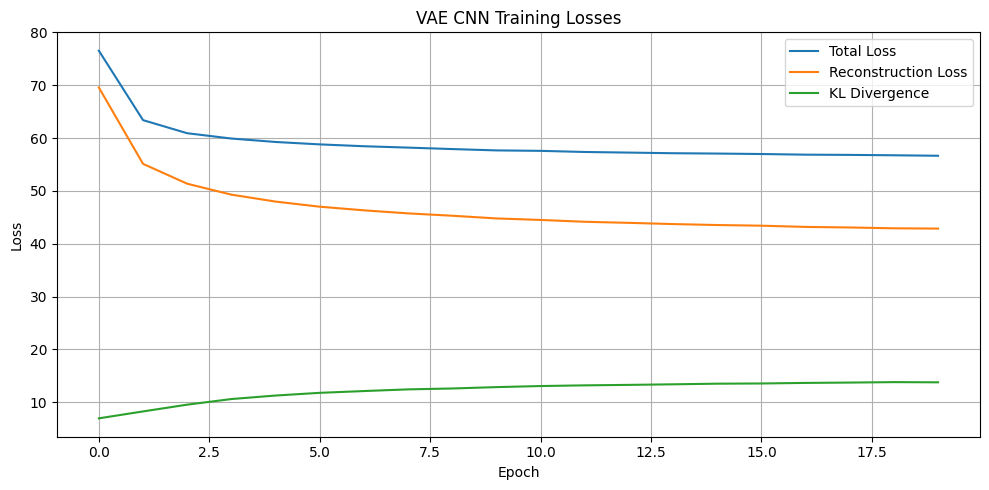

In [106]:
plt.figure(figsize=(10, 5))
plt.plot(vae_cnn_losses, label='Total Loss')
plt.plot(vae_cnn_recon, label='Reconstruction Loss')
plt.plot(vae_cnn_kl, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE CNN Training Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


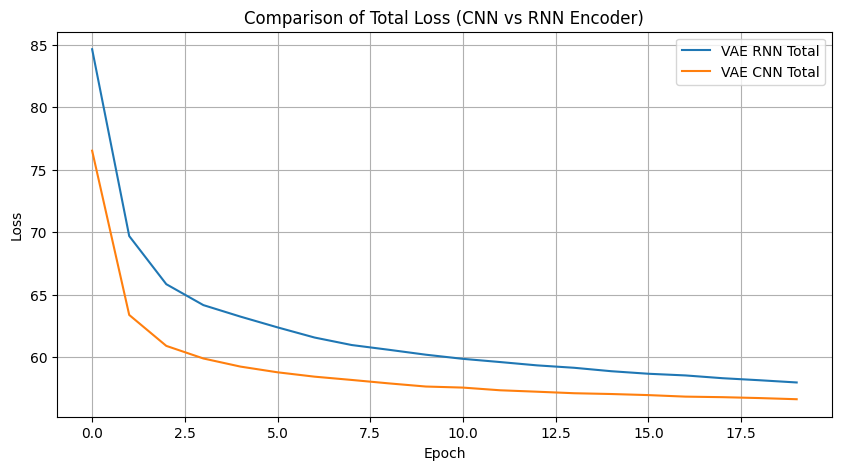

In [107]:
#(Compare VAEs)
plt.figure(figsize=(10, 5))
plt.plot(vae_train_losses, label='VAE RNN Total')
plt.plot(vae_cnn_losses, label='VAE CNN Total')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Total Loss (CNN vs RNN Encoder)')
plt.legend()
plt.grid(True)
plt.show()


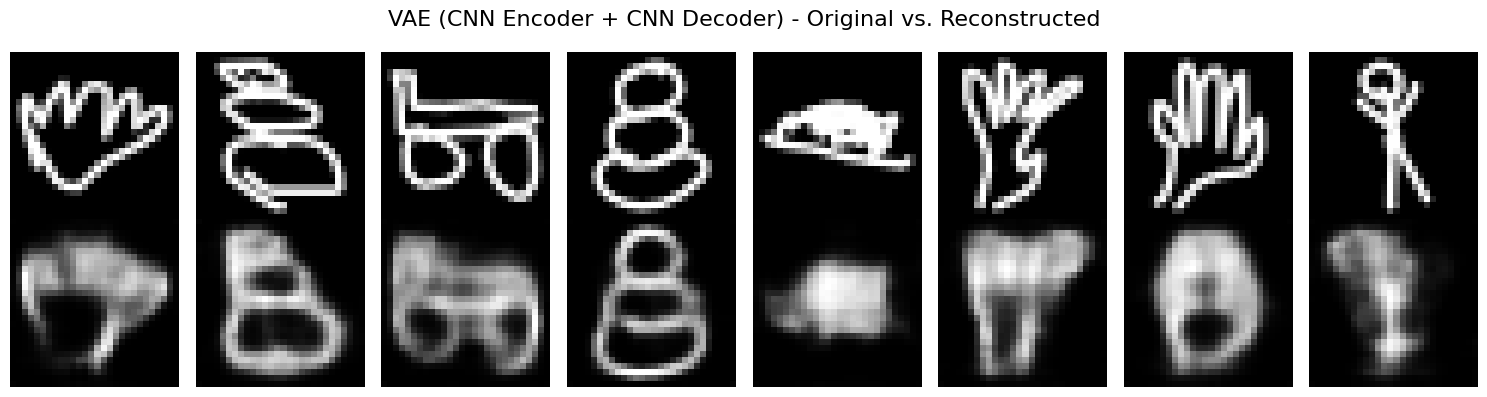

In [108]:
vae_cnn.eval()
with torch.no_grad():
    x = next(iter(test_loader))[0][:8].unsqueeze(1).to(device)
    recon, _, _ = vae_cnn(x)

fig, axs = plt.subplots(2, 8, figsize=(15, 4))
for i in range(8):
    axs[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", size=14)
axs[1, 0].set_ylabel("Reconstructed", size=14)
plt.suptitle("VAE (CNN Encoder + CNN Decoder) - Original vs. Reconstructed", fontsize=16)
plt.tight_layout()
plt.show()


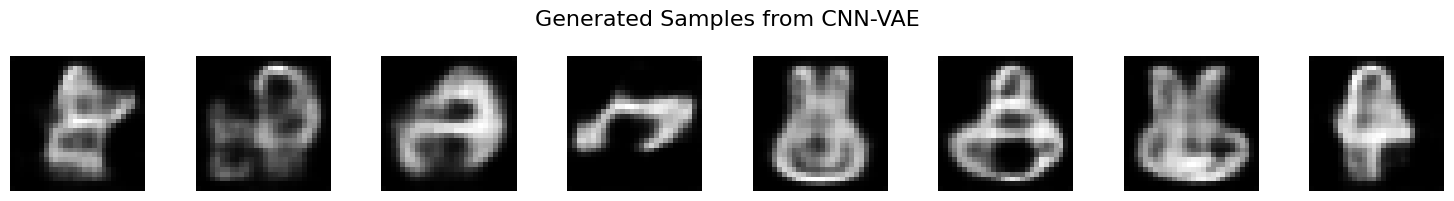

In [109]:
with torch.no_grad():
    z = torch.randn(8, 32).to(device)  # should make this 32 change to a robust way.
    gen_images = vae_cnn.decode(z)

fig, axs = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    axs[i].imshow(gen_images[i].cpu().squeeze(), cmap='gray')
    axs[i].axis('off')
plt.suptitle("Generated Samples from CNN-VAE", fontsize=16)
plt.tight_layout()
plt.show()


### Part 2.3

In [68]:
class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, output_dim=5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)


In [69]:
classifier = MLP(hidden_dim=256).to(device)
classifier.load_state_dict(torch.load("quickdraw_classifier.pth"))
classifier.eval()


MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

In [84]:
import scipy.stats

def compute_inception_score(images, classifier, splits=10):
    classifier.eval()
    preds = []

    with torch.no_grad():
        for i in range(0, len(images), 64):
            batch = images[i:i+64].to(device)
            if batch.ndim == 4:
                batch = batch.view(batch.size(0), -1)  # flatten
            outputs = classifier(batch)
            preds.append(outputs.cpu().numpy())

    preds = np.vstack(preds)
    split_scores = []

    for k in range(splits):
        part = preds[k * (len(preds) // splits):(k + 1) * (len(preds) // splits)]
        py = np.mean(part, axis=0)
        scores = [scipy.stats.entropy(p, py) for p in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


In [85]:
from scipy.linalg import sqrtm

def compute_fid(real, fake):
    mu1, sigma1 = real.mean(axis=0), np.cov(real, rowvar=False)
    mu2, sigma2 = fake.mean(axis=0), np.cov(fake, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)


In [86]:
def extract_features(images, classifier):
    features = []

    def hook_fn(module, input, output):
        features.append(output.detach().cpu())

    handle = classifier.fc1.register_forward_hook(hook_fn)

    with torch.no_grad():
        for i in range(0, len(images), 64):
            batch = images[i:i+64]

            # Flatten to (B, 784) if necessary
            if batch.ndim == 4:  # (B, 1, 28, 28)
                batch = batch.view(batch.size(0), -1)
            elif batch.ndim == 3:  # (B, 28, 28)
                batch = batch.view(batch.size(0), -1)
            elif batch.ndim == 2:  # already (B, 784)
                pass
            else:
                raise ValueError(f"Unexpected input shape: {batch.shape}")

            batch = batch.to(device)
            classifier(batch)

    handle.remove()
    return torch.cat(features).numpy()


In [111]:
# Generate 1000 samples from each VAE
num_samples = 1000
latent_dim = 32

# CNN-VAE
z_cnn = torch.randn(num_samples, latent_dim).to(device)
samples_cnn = vae_cnn.decode(z_cnn).detach().cpu()

# RNN-VAE
z_rnn = torch.randn(num_samples, latent_dim).to(device)
samples_rnn = vae.decode(z_rnn).detach().cpu()

# Load 1000 real images (properly)
real_loader = DataLoader(test_tensor, batch_size=64, shuffle=False)
real_images = []
for batch in real_loader:
    real_images.append(batch)
    if sum([x.size(0) for x in real_images]) >= num_samples:
        break

real_images = torch.cat(real_images, dim=0)[:num_samples].cpu()  # Shape: (1000, 1, 28, 28)

# Flatten for classifier
samples_cnn_flat = samples_cnn.view(num_samples, -1)
samples_rnn_flat = samples_rnn.view(num_samples, -1)
real_flat = real_images.view(num_samples, -1)

# IS
is_cnn_mean, is_cnn_std = compute_inception_score(samples_cnn_flat, classifier)
is_rnn_mean, is_rnn_std = compute_inception_score(samples_rnn_flat, classifier)

# FID
features_real = extract_features(real_images, classifier)
features_cnn = extract_features(samples_cnn, classifier)
features_rnn = extract_features(samples_rnn, classifier)

fid_cnn = compute_fid(features_real, features_cnn)
fid_rnn = compute_fid(features_real, features_rnn)

# Show results
print("Inception Score:")
print(f"CNN-VAE: {is_cnn_mean:.3f} ± {is_cnn_std:.3f}")
print(f"RNN-VAE: {is_rnn_mean:.3f} ± {is_rnn_std:.3f}")

print("\nFrechet Inception Distance:")
print(f"CNN-VAE: {fid_cnn:.3f}")
print(f"RNN-VAE: {fid_rnn:.3f}")


Inception Score:
CNN-VAE: 3.987 ± 0.090
RNN-VAE: 4.034 ± 0.103

Frechet Inception Distance:
CNN-VAE: 10.321
RNN-VAE: 14.413


#### Some hyperparam trials

In [ ]:
## Trying improving the model
class ImprovedVAE_CNN(nn.Module):
    def __init__(self, latent_dim=64):
        super(ImprovedVAE_CNN, self).__init__()

        # Encoder: 28x28 -> 7x7, then expand filters
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),   # 28 → 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14 → 7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 7 → 7 (deeper features)
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)

        # Decoder: reverse path
        self.fc_decode = nn.Linear(latent_dim, 128 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),  # 7x7 → 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 7 → 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),    # 14 → 28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 128, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:
def vae_loss_function_annealed(recon_x, x, mu, logvar, kl_weight=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl, recon_loss, kl


In [ ]:
improved_vae = ImprovedVAE_CNN(latent_dim=64).to(device)
optimizer = torch.optim.Adam(improved_vae.parameters(), lr=1e-3)

improved_losses = []
improved_kl = []
improved_recon = []

for epoch in range(num_epochs):
    improved_vae.train()
    total_loss = total_kl = total_recon = 0

    kl_weight = min(1.0, epoch / 10.0)  # linear annealing over first 10 epochs

    for batch in train_loader:
        x = batch[0].unsqueeze(1).to(device)
        recon, mu, logvar = improved_vae(x)
        loss, recon_loss, kl = vae_loss_function_annealed(recon, x, mu, logvar, kl_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    improved_losses.append(avg_loss)
    improved_kl.append(total_kl / len(train_loader.dataset))
    improved_recon.append(total_recon / len(train_loader.dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Recon: {improved_recon[-1]:.4f}, KL: {improved_kl[-1]:.4f} (w={kl_weight:.2f})")


Epoch 1/20, Loss: 51.8927, Recon: 51.8927, KL: 395.2787 (w=0.00)
Epoch 2/20, Loss: 38.2506, Recon: 30.1289, KL: 81.2167 (w=0.10)
Epoch 3/20, Loss: 38.3406, Recon: 26.1658, KL: 60.8739 (w=0.20)
Epoch 4/20, Loss: 41.2223, Recon: 26.4412, KL: 49.2706 (w=0.30)
Epoch 5/20, Loss: 44.3565, Recon: 27.8517, KL: 41.2621 (w=0.40)
Epoch 6/20, Loss: 47.4128, Recon: 29.8450, KL: 35.1357 (w=0.50)
Epoch 7/20, Loss: 50.2481, Recon: 32.1709, KL: 30.1286 (w=0.60)
Epoch 8/20, Loss: 52.5749, Recon: 34.4256, KL: 25.9276 (w=0.70)
Epoch 9/20, Loss: 54.4728, Recon: 36.7022, KL: 22.2132 (w=0.80)
Epoch 10/20, Loss: 56.2713, Recon: 38.9893, KL: 19.2022 (w=0.90)
Epoch 11/20, Loss: 57.7187, Recon: 41.1616, KL: 16.5572 (w=1.00)
Epoch 12/20, Loss: 57.3907, Recon: 41.3372, KL: 16.0535 (w=1.00)
Epoch 13/20, Loss: 57.2321, Recon: 41.3480, KL: 15.8841 (w=1.00)
Epoch 14/20, Loss: 57.0481, Recon: 41.2477, KL: 15.8004 (w=1.00)
Epoch 15/20, Loss: 56.9065, Recon: 41.2625, KL: 15.6440 (w=1.00)
Epoch 16/20, Loss: 56.7969, Recon

In [ ]:
# Generate 1000 samples from improved VAE
num_samples = 1000
latent_dim = 64  # updated latent size

z_improved = torch.randn(num_samples, latent_dim).to(device)
samples_improved = improved_vae.decode(z_improved).detach().cpu()

# Flatten for classifier
samples_improved_flat = samples_improved.view(num_samples, -1)

# Inception Score
is_improved_mean, is_improved_std = compute_inception_score(samples_improved_flat, classifier)

# FID
features_improved = extract_features(samples_improved, classifier)
fid_improved = compute_fid(features_real, features_improved)

# Report
print("📈 Improved CNN-VAE Results")
print(f"🔬 Inception Score: {is_improved_mean:.3f} ± {is_improved_std:.3f}")
print(f"📏 FID: {fid_improved:.3f}")


📈 Improved CNN-VAE Results
🔬 Inception Score: 3.959 ± 0.154
📏 FID: 11.391


In [ ]:
class ImprovedVAE_CNN_v2(nn.Module):
    def __init__(self, latent_dim=32):
        super(ImprovedVAE_CNN_v2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28x28 → 14x14
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 14x14 → 7x7
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 7x7 → 7x7
            nn.LeakyReLU(0.2)
        )

        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 128 * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),  # 7x7
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 7 → 14
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),    # 14 → 28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(-1, 128, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [ ]:
improved_vae_v2 = ImprovedVAE_CNN_v2(latent_dim=32).to(device)
optimizer = torch.optim.Adam(improved_vae_v2.parameters(), lr=1e-3)

losses, kl_vals, recon_vals = [], [], []

for epoch in range(num_epochs):
    improved_vae_v2.train()
    total_loss, total_kl, total_recon = 0, 0, 0

    kl_weight = min(1.0, epoch / 10.0)

    for batch in train_loader:
        x = batch[0].unsqueeze(1).to(device)
        recon, mu, logvar = improved_vae_v2(x)
        loss, recon_loss, kl = vae_loss_function_annealed(recon, x, mu, logvar, kl_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_kl += kl.item()
        total_recon += recon_loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    kl_vals.append(total_kl / len(train_loader.dataset))
    recon_vals.append(total_recon / len(train_loader.dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Recon: {recon_vals[-1]:.4f}, KL: {kl_vals[-1]:.4f} (w={kl_weight:.2f})")


Epoch 1/20, Loss: 49.8060, Recon: 49.8060, KL: 170.2780 (w=0.00)
Epoch 2/20, Loss: 36.7700, Recon: 30.6185, KL: 61.5156 (w=0.10)
Epoch 3/20, Loss: 39.0807, Recon: 29.3698, KL: 48.5546 (w=0.20)
Epoch 4/20, Loss: 42.2987, Recon: 30.1120, KL: 40.6225 (w=0.30)
Epoch 5/20, Loss: 45.1842, Recon: 31.3100, KL: 34.6854 (w=0.40)
Epoch 6/20, Loss: 47.8964, Recon: 32.8615, KL: 30.0699 (w=0.50)
Epoch 7/20, Loss: 50.2559, Recon: 34.4372, KL: 26.3645 (w=0.60)
Epoch 8/20, Loss: 52.3799, Recon: 36.1415, KL: 23.1977 (w=0.70)
Epoch 9/20, Loss: 54.2932, Recon: 37.9159, KL: 20.4716 (w=0.80)
Epoch 10/20, Loss: 55.9140, Recon: 39.6770, KL: 18.0411 (w=0.90)
Epoch 11/20, Loss: 57.3566, Recon: 41.5807, KL: 15.7759 (w=1.00)
Epoch 12/20, Loss: 57.0972, Recon: 41.6549, KL: 15.4423 (w=1.00)
Epoch 13/20, Loss: 56.9637, Recon: 41.6057, KL: 15.3579 (w=1.00)
Epoch 14/20, Loss: 56.8150, Recon: 41.5471, KL: 15.2679 (w=1.00)
Epoch 15/20, Loss: 56.6942, Recon: 41.5414, KL: 15.1527 (w=1.00)
Epoch 16/20, Loss: 56.5212, Recon

In [ ]:
# Generate 1000 samples from improved VAE v2
num_samples = 1000
latent_dim = 32  # new latent size

z_v2 = torch.randn(num_samples, latent_dim).to(device)
samples_v2 = improved_vae_v2.decode(z_v2).detach().cpu()

# Flatten for classifier
samples_v2_flat = samples_v2.view(num_samples, -1)

# Inception Score
is_v2_mean, is_v2_std = compute_inception_score(samples_v2_flat, classifier)

# FID
features_v2 = extract_features(samples_v2, classifier)
fid_v2 = compute_fid(features_real, features_v2)

# Show results
print("📈 Improved CNN-VAE v2 Results")
print(f"🔬 Inception Score: {is_v2_mean:.3f} ± {is_v2_std:.3f}")
print(f"📏 FID: {fid_v2:.3f}")


📈 Improved CNN-VAE v2 Results
🔬 Inception Score: 4.059 ± 0.096
📏 FID: 9.805


### Part 4.4

In [112]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=32, num_classes=5):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Label embedding to image shape (1, 28, 28)
        self.label_embed = nn.Linear(num_classes, 28 * 28)

        # Encoder: input channels = 1 (image) + 1 (label)
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, 4, 2, 1),  # 28 → 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 14 → 7
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder: input = latent + label
        self.decoder_input = nn.Linear(latent_dim + num_classes, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7 → 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # 14 → 28
            nn.Sigmoid()
        )

    def encode(self, x, y):
        y_embed = self.label_embed(y).reshape(-1, 1, 28, 28)  # view'ı reshape yaptım
        x_cond = torch.cat([x, y_embed], dim=1)  # (B, 2, 28, 28)
        h = self.encoder(x_cond).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z_cond = torch.cat([z, y], dim=1)
        x = self.decoder_input(z_cond).view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar


In [113]:
# One-hot encode labels
def one_hot(labels, num_classes=5):
    return torch.eye(num_classes)[labels]


In [114]:
train_tensor.shape

torch.Size([20000, 1, 28, 28])

In [115]:
# Rebuild train_loader to return both images and labels
train_dataset = TensorDataset(train_tensor, torch.tensor(train_labels))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [116]:
cvae = ConditionalVAE(latent_dim=32, num_classes=5).to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

cvae_losses = []
cvae_recon_losses = []
cvae_kl_losses = []

num_epochs = 20

for epoch in range(num_epochs):
    cvae.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    for images, labels in train_loader:
        images = images.to(device)  # (B, 1, 28, 28)  #.unsqueeze(1)
        labels_onehot = one_hot(labels, num_classes=5).to(device)  # (B, 5)

        recon, mu, logvar = cvae(images, labels_onehot)

        # Standard VAE loss
        recon_loss = nn.functional.mse_loss(recon, images, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    cvae_losses.append(avg_loss)
    cvae_recon_losses.append(total_recon / len(train_loader.dataset))
    cvae_kl_losses.append(total_kl / len(train_loader.dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Recon: {cvae_recon_losses[-1]:.4f}, KL: {cvae_kl_losses[-1]:.4f}")


Epoch 1/20, Loss: 72.3630, Recon: 67.0943, KL: 5.2686
Epoch 2/20, Loss: 61.0923, Recon: 54.1007, KL: 6.9916
Epoch 3/20, Loss: 59.3787, Recon: 50.8271, KL: 8.5517
Epoch 4/20, Loss: 58.3945, Recon: 48.9542, KL: 9.4403
Epoch 5/20, Loss: 57.7839, Recon: 47.7568, KL: 10.0272
Epoch 6/20, Loss: 57.2292, Recon: 46.8116, KL: 10.4176
Epoch 7/20, Loss: 56.9327, Recon: 46.1647, KL: 10.7679
Epoch 8/20, Loss: 56.6173, Recon: 45.6223, KL: 10.9950
Epoch 9/20, Loss: 56.3505, Recon: 45.1571, KL: 11.1934
Epoch 10/20, Loss: 56.0660, Recon: 44.7360, KL: 11.3300
Epoch 11/20, Loss: 55.9187, Recon: 44.4303, KL: 11.4884
Epoch 12/20, Loss: 55.7437, Recon: 44.1508, KL: 11.5929
Epoch 13/20, Loss: 55.5742, Recon: 43.8462, KL: 11.7281
Epoch 14/20, Loss: 55.4538, Recon: 43.5586, KL: 11.8952
Epoch 15/20, Loss: 55.3480, Recon: 43.4074, KL: 11.9405
Epoch 16/20, Loss: 55.2593, Recon: 43.2167, KL: 12.0426
Epoch 17/20, Loss: 55.1657, Recon: 43.0470, KL: 12.1187
Epoch 18/20, Loss: 55.0426, Recon: 42.9029, KL: 12.1398
Epoch

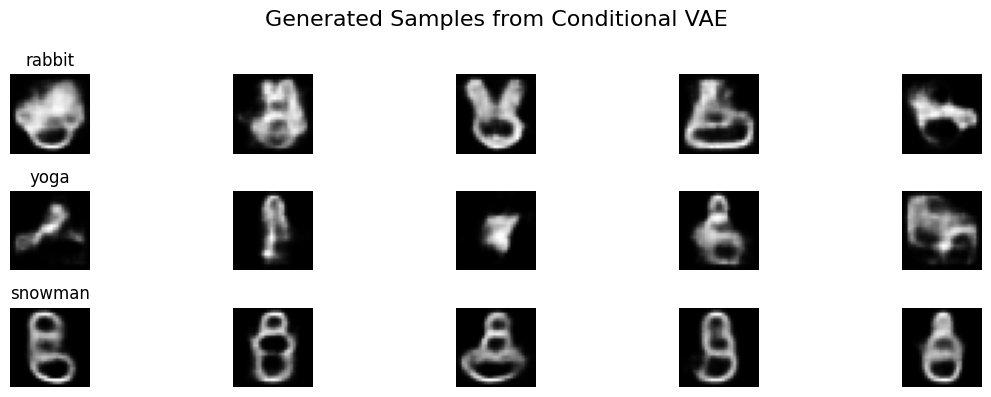

In [117]:
# Sample and visualize
import matplotlib.pyplot as plt

cvae.eval()
num_samples = 5
class_ids = [0, 1, 3]
class_names = ['rabbit', 'yoga', 'snowman']

fig, axs = plt.subplots(len(class_ids), num_samples, figsize=(12, 4))

with torch.no_grad():
    for row_idx, class_id in enumerate(class_ids):
        # Prepare conditional input
        y = torch.full((num_samples,), class_id, dtype=torch.long)
        y_onehot = one_hot(y, num_classes=5).to(device)
        z = torch.randn(num_samples, 32).to(device)
        samples = cvae.decode(z, y_onehot).cpu()

        for col_idx in range(num_samples):
            axs[row_idx, col_idx].imshow(samples[col_idx].squeeze(), cmap='gray')
            axs[row_idx, col_idx].axis('off')
            if col_idx == 0:
                axs[row_idx, col_idx].set_title(class_names[row_idx])

plt.suptitle("Generated Samples from Conditional VAE", fontsize=16)
plt.tight_layout()
plt.show()


In [118]:
# Flatten and classify
all_preds = []
all_probs = []

with torch.no_grad():
    for class_id in class_ids:
        y = torch.full((num_samples,), class_id, dtype=torch.long)
        y_onehot = one_hot(y, num_classes=5).to(device)
        z = torch.randn(num_samples, 32).to(device)
        samples = cvae.decode(z, y_onehot).cpu()
        flat_samples = samples.view(num_samples, -1).to(device)

        outputs = classifier(flat_samples)
        probs = outputs.cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_preds.append(preds)
        all_probs.append(probs)

# Show results
for idx, class_id in enumerate(class_ids):
    print(f"\nClass {class_names[idx]} (Label {class_id}):")
    for i in range(num_samples):
        predicted = all_preds[idx][i]
        confidence = np.max(all_probs[idx][i])
        print(f"  Sample {i+1}: Predicted = {predicted}, Confidence = {confidence:.2f}")



Class rabbit (Label 0):
  Sample 1: Predicted = 0, Confidence = 1.00
  Sample 2: Predicted = 0, Confidence = 1.00
  Sample 3: Predicted = 4, Confidence = 0.96
  Sample 4: Predicted = 0, Confidence = 1.00
  Sample 5: Predicted = 0, Confidence = 1.00

Class yoga (Label 1):
  Sample 1: Predicted = 1, Confidence = 1.00
  Sample 2: Predicted = 1, Confidence = 0.99
  Sample 3: Predicted = 1, Confidence = 0.96
  Sample 4: Predicted = 1, Confidence = 1.00
  Sample 5: Predicted = 1, Confidence = 1.00

Class snowman (Label 3):
  Sample 1: Predicted = 3, Confidence = 1.00
  Sample 2: Predicted = 3, Confidence = 1.00
  Sample 3: Predicted = 3, Confidence = 1.00
  Sample 4: Predicted = 2, Confidence = 0.62
  Sample 5: Predicted = 3, Confidence = 0.99


In [119]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

cvae.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for images, lbls in test_loader:
        images = images.unsqueeze(1).to(device)
        onehot_labels = one_hot(lbls, num_classes=5).to(device)

        mu, _ = cvae.encode(images, onehot_labels)  # get mean only
        latent_vectors.append(mu.cpu())
        labels.extend(lbls.numpy())

latent_vectors = torch.cat(latent_vectors).numpy()
labels = np.array(labels)


In [120]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)


<ipython-input-121-a2ad857029b5>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap=cm.get_cmap('tab10', 5), s=10, alpha=0.8)


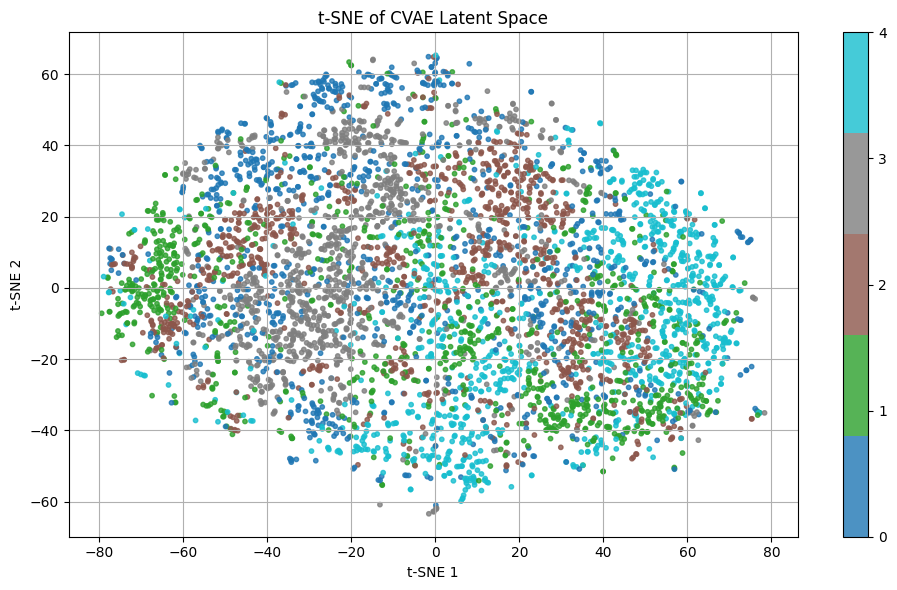

In [121]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap=cm.get_cmap('tab10', 5), s=10, alpha=0.8)
plt.colorbar(scatter, ticks=range(5))
plt.title("t-SNE of CVAE Latent Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()
